In [10]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Loading data

In [11]:
test = pd.read_csv('/content/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('/content/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('/content/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('/content/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('/content/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                      'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [12]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [13]:
print(f'Train rows: {train.shape[0]}')
print(f'Train columns: {train.shape[1]}')

display(train.head().T)
display(train.describe())

Train rows: 2935849
Train columns: 10


,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [14]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]

In [15]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

display(train_monthly.head(10).T)
display(train_monthly.describe().T)

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,33.00,482.00,491.00,839.00,1007.00,1010.00,1023.00,1204.00,1224.00,1247.00
item_cnt,1.00,1.00,1.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00
item_cnt_month,2.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
date_block_num,593829.00,20.18,9.14,0.00,13.00,22.00,28.00,33.00
shop_id,593829.00,32.07,16.90,2.00,19.00,31.00,47.00,59.00
item_id,593829.00,10015.02,6181.82,30.00,4418.00,9171.00,15334.00,22167.00
item_cnt,593829.00,2.10,2.31,0.00,1.00,1.00,2.00,20.00
item_cnt_month,482536.00,2.07,2.17,0.00,1.00,1.00,2.00,20.00


In [16]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [17]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,32,2,2,0,2,0,0,1,0,0,0,0,1,0


In [18]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)

Train and validation sets

In [19]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [20]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (200327, 12)
Validation set (22259, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
207604,0,0,0,0,0,0,0,0,0,0,0,0
45150,0,0,0,0,0,0,0,0,0,0,0,0
143433,0,0,4,2,1,2,2,1,0,0,0,1
202144,0,0,0,0,0,0,0,0,0,0,0,0
136088,0,0,0,0,0,0,0,1,0,0,1,0


Time-series shape (data points, time-steps, features).

In [21]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (200327, 12, 1)
Validation set reshaped (22259, 12, 1)


Regular LSTM model

In [22]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(L.LSTM(1, activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 12, 6)             408       
                                                                 
 lstm_2 (LSTM)               (None, 1)                 32        
                                                                 
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,061
Trainable params: 1,061
Non-trainabl

In [23]:
lstm_history = lstm_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/20
1566/1566 - 37s - loss: 1.4853 - val_loss: 1.3374 - 37s/epoch - 24ms/step
Epoch 2/20
1566/1566 - 31s - loss: 1.3638 - val_loss: 1.2778 - 31s/epoch - 20ms/step
Epoch 3/20
1566/1566 - 31s - loss: 1.2879 - val_loss: 1.2232 - 31s/epoch - 20ms/step
Epoch 4/20
1566/1566 - 31s - loss: 1.2365 - val_loss: 1.2004 - 31s/epoch - 20ms/step
Epoch 5/20
1566/1566 - 31s - loss: 1.2115 - val_loss: 1.1956 - 31s/epoch - 20ms/step
Epoch 6/20
1566/1566 - 31s - loss: 1.1976 - val_loss: 1.1785 - 31s/epoch - 20ms/step
Epoch 7/20
1566/1566 - 31s - loss: 1.1896 - val_loss: 1.1742 - 31s/epoch - 20ms/step
Epoch 8/20
1566/1566 - 33s - loss: 1.1850 - val_loss: 1.1722 - 33s/epoch - 21ms/step
Epoch 9/20
1566/1566 - 33s - loss: 1.1819 - val_loss: 1.1654 - 33s/epoch - 21ms/step
Epoch 10/20
1566/1566 - 31s - loss: 1.1796 - val_loss: 1.1635 - 31s/epoch - 20ms/step
Epoch 11/20
1566/1566 - 33s - loss: 1.1771 - val_loss: 1.1634 - 33s/epoch - 21ms/step
Epoch 12/20
1566/1566 - 31s - loss: 1.1751 - val_loss: 1.1608 -

LSTM Autoencoder

In [24]:
encoder_decoder = Sequential()
encoder_decoder.add(L.LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(1, activation='relu'))
encoder_decoder.add(L.RepeatVector(serie_size))
encoder_decoder.add(L.LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.TimeDistributed(L.Dense(1)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 12)            672       
                                                                 
 lstm_4 (LSTM)               (None, 12, 6)             456       
                                                                 
 lstm_5 (LSTM)               (None, 1)                 32        
                                                                 
 repeat_vector (RepeatVector  (None, 12, 1)            0         
 )                                                               
                                                                 
 lstm_6 (LSTM)               (None, 12, 12)            672       
                                                                 
 lstm_7 (LSTM)               (None, 12, 6)             456       
                                                      

In [25]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train, 
                                              batch_size=batch, 
                                              epochs=epochs, 
                                              verbose=2)

Epoch 1/20
1566/1566 - 58s - loss: 1.6691 - 58s/epoch - 37ms/step
Epoch 2/20
1566/1566 - 50s - loss: 1.6026 - 50s/epoch - 32ms/step
Epoch 3/20
1566/1566 - 50s - loss: 1.2675 - 50s/epoch - 32ms/step
Epoch 4/20
1566/1566 - 52s - loss: 1.2306 - 52s/epoch - 33ms/step
Epoch 5/20
1566/1566 - 51s - loss: 1.2004 - 51s/epoch - 32ms/step
Epoch 6/20
1566/1566 - 51s - loss: 1.1635 - 51s/epoch - 32ms/step
Epoch 7/20
1566/1566 - 51s - loss: 1.1252 - 51s/epoch - 32ms/step
Epoch 8/20
1566/1566 - 51s - loss: 1.0868 - 51s/epoch - 32ms/step
Epoch 9/20
1566/1566 - 52s - loss: 1.0597 - 52s/epoch - 33ms/step
Epoch 10/20
1566/1566 - 50s - loss: 1.0454 - 50s/epoch - 32ms/step
Epoch 11/20
1566/1566 - 50s - loss: 1.0372 - 50s/epoch - 32ms/step
Epoch 12/20
1566/1566 - 51s - loss: 1.0313 - 51s/epoch - 33ms/step
Epoch 13/20
1566/1566 - 52s - loss: 1.0241 - 52s/epoch - 33ms/step
Epoch 14/20
1566/1566 - 50s - loss: 1.0187 - 50s/epoch - 32ms/step
Epoch 15/20
1566/1566 - 51s - loss: 1.0119 - 51s/epoch - 33ms/step
Epoc

In [26]:
rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
encoder_decoder.layers

In [27]:
rpt_vector_layer_output = rpt_vector_layer.predict(X_train[:1])
print('Repeat vector output shape', rpt_vector_layer_output.shape)
print('Repeat vector output sample')
print(rpt_vector_layer_output[0])

1/1 [==============================] - 1s 517ms/step
Repeat vector output shape (1, 12, 1)
Repeat vector output sample
[[0.00028818]
 [0.00028818]
 [0.00028818]
 [0.00028818]
 [0.00028818]
 [0.00028818]
 [0.00028818]
 [0.00028818]
 [0.00028818]
 [0.00028818]
 [0.00028818]
 [0.00028818]]


In [28]:
time_dist_layer_output = time_dist_layer.predict(X_train[:1])
print('Time distributed output shape', time_dist_layer_output.shape)
print('Time distributed output sample')
print(time_dist_layer_output[0])

1/1 [==============================] - 1s 690ms/step
Time distributed output shape (1, 12, 6)
Time distributed output sample
[[7.50933439e-02 1.89989716e-01 4.92752224e-01 1.55387759e-01
  1.25811890e-01 1.32486776e-01]
 [2.98484623e-01 3.22212785e-01 4.27442640e-01 1.18478894e-01
  6.89191446e-02 1.24651588e-01]
 [5.00297844e-01 4.14153814e-01 3.06291759e-01 1.13242514e-01
  3.71761695e-02 9.59867537e-02]
 [6.74075067e-01 4.86613423e-01 2.23264530e-01 1.19222693e-01
  1.85969938e-02 6.41924739e-02]
 [8.26024234e-01 5.46575069e-01 1.64635822e-01 1.23407371e-01
  8.42848513e-03 4.29903567e-02]
 [9.62058604e-01 5.98279774e-01 1.22163326e-01 1.24437712e-01
  3.46186408e-03 2.89187301e-02]
 [1.08813310e+00 6.44712269e-01 9.09182057e-02 1.23788640e-01
  1.28523319e-03 1.95404273e-02]
 [1.20905256e+00 6.88105583e-01 6.77338839e-02 1.23693138e-01
  4.28990548e-04 1.32507058e-02]
 [1.32896507e+00 7.30043709e-01 5.04645966e-02 1.26756281e-01
  1.27587438e-04 9.01258364e-03]
 [1.45035219e+00 7.7

In [29]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)

In [30]:
train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_valid)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

696/696 [==============================] - 5s 6ms/step
Encoded time-series shape (200327, 1)
Encoded time-series sample [0.00028818]


In [31]:
train['encoded'] = train_encoded
train['label'] = Y_train

valid['encoded'] = validation_encoded
valid['label'] = Y_valid

train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,encoded,label
207604,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0
45150,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0
143433,0,0,4,2,1,2,2,1,0,0,0,1,0.76,1
202144,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0
136088,0,0,0,0,0,0,0,1,0,0,1,0,0.06,1
121675,0,0,0,0,0,1,0,0,0,0,0,0,0.02,0
185281,0,0,0,0,0,0,0,0,0,0,0,0,0.00,1
70087,0,0,0,0,0,0,0,0,3,0,1,3,0.24,0
105249,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0
183257,0,0,0,0,0,3,0,1,0,0,0,1,0.11,0


In [32]:
last_month = serie_size - 1
Y_train_encoded = train['label']
train.drop('label', axis=1, inplace=True)
X_train_encoded = train[[last_month, 'encoded']]

Y_valid_encoded = valid['label']
valid.drop('label', axis=1, inplace=True)
X_valid_encoded = valid[[last_month, 'encoded']]

print("Train set", X_train_encoded.shape)
print("Validation set", X_valid_encoded.shape)

Train set (200327, 2)
Validation set (22259, 2)


In [33]:
X_train_encoded.head()

,11,encoded
207604,0,0.00
45150,0,0.00
143433,1,0.76
202144,0,0.00
136088,0,0.06


In [34]:
mlp_model = Sequential()
mlp_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train_encoded.shape[1]))
mlp_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(1))
mlp_model.summary()

adam = optimizers.Adam(lr)
mlp_model.compile(loss='mse', optimizer=adam)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                30        
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [35]:
mlp_history = mlp_model.fit(X_train_encoded.values, Y_train_encoded.values, epochs=epochs, batch_size=batch, validation_data=(X_valid_encoded, Y_valid_encoded), verbose=2)

Epoch 1/20
1566/1566 - 5s - loss: 1.4381 - val_loss: 1.2449 - 5s/epoch - 3ms/step
Epoch 2/20
1566/1566 - 3s - loss: 1.2517 - val_loss: 1.1939 - 3s/epoch - 2ms/step
Epoch 3/20
1566/1566 - 4s - loss: 1.2283 - val_loss: 1.1899 - 4s/epoch - 2ms/step
Epoch 4/20
1566/1566 - 3s - loss: 1.2263 - val_loss: 1.1891 - 3s/epoch - 2ms/step
Epoch 5/20
1566/1566 - 3s - loss: 1.2256 - val_loss: 1.1885 - 3s/epoch - 2ms/step
Epoch 6/20
1566/1566 - 3s - loss: 1.2250 - val_loss: 1.1881 - 3s/epoch - 2ms/step
Epoch 7/20
1566/1566 - 4s - loss: 1.2244 - val_loss: 1.1875 - 4s/epoch - 2ms/step
Epoch 8/20
1566/1566 - 3s - loss: 1.2234 - val_loss: 1.1866 - 3s/epoch - 2ms/step
Epoch 9/20
1566/1566 - 3s - loss: 1.2224 - val_loss: 1.1853 - 3s/epoch - 2ms/step
Epoch 10/20
1566/1566 - 3s - loss: 1.2216 - val_loss: 1.1843 - 3s/epoch - 2ms/step
Epoch 11/20
1566/1566 - 4s - loss: 1.2207 - val_loss: 1.1841 - 4s/epoch - 3ms/step
Epoch 12/20
1566/1566 - 3s - loss: 1.2200 - val_loss: 1.1826 - 3s/epoch - 2ms/step
Epoch 13/20
1

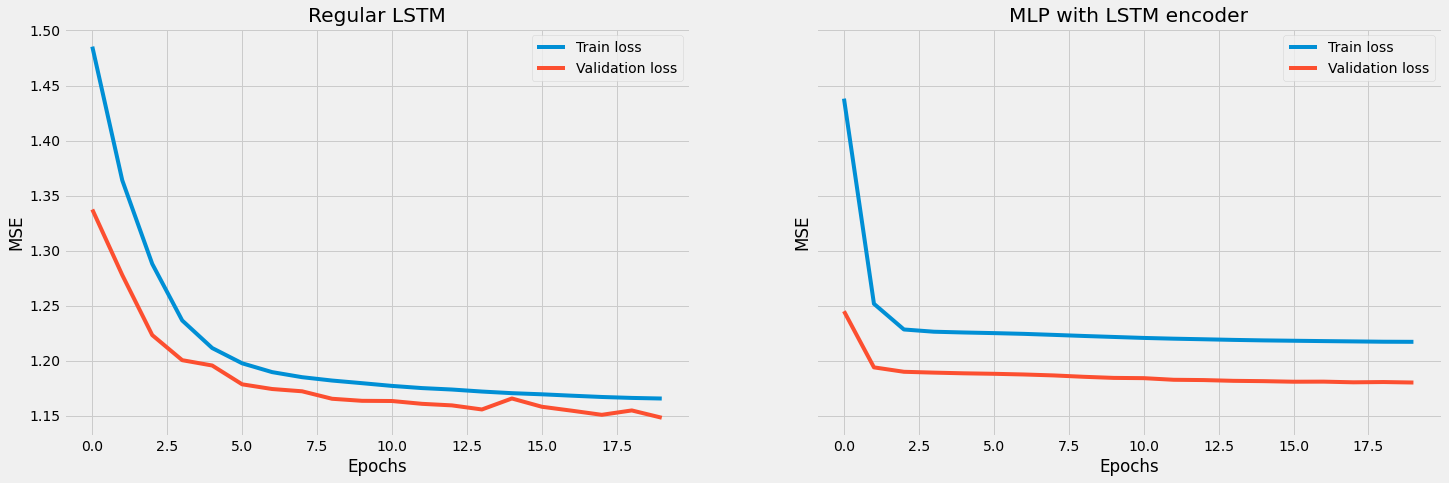

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular LSTM')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(mlp_history.history['loss'], label='Train loss')
ax2.plot(mlp_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('MLP with LSTM encoder')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

plt.show()

In [37]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_val_pred = lstm_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

696/696 [==============================] - 4s 6ms/step
Train rmse: 1.07885991492277
Validation rmse: 1.071515970020857


In [38]:
mlp_train_pred2 = mlp_model.predict(X_train_encoded.values)
mlp_val_pred2 = mlp_model.predict(X_valid_encoded.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_encoded, mlp_train_pred2)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_encoded, mlp_val_pred2)))

696/696 [==============================] - 1s 2ms/step
Train rmse: 1.1030862791508216
Validation rmse: 1.0863422459933352


In [39]:
latest_records = monthly_series.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Regular LSTM model test predictions

In [40]:
X_test = X_test[[(i + (34 - serie_size)) for i in range(serie_size)]]
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [41]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(214200, 12, 1)


In [42]:
lstm_test_pred = lstm_model.predict(X_test_reshaped)

6694/6694 [==============================] - 43s 6ms/step


MLP with LSTM encoded feature test predictions

In [43]:
test_encoded = encoder.predict(X_test_reshaped)

6694/6694 [==============================] - 41s 6ms/step


In [44]:
X_test['encoded'] = test_encoded
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33,encoded
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00,0.27
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00,0.25
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.02
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [45]:
X_test_encoded = X_test[[33, 'encoded']]
print("Train set", X_test_encoded.shape)
X_test_encoded.head()

Train set (214200, 2)


,33,encoded
0,0.00,0.27
1,0.00,0.00
2,1.00,0.25
3,0.00,0.02
4,0.00,0.00


In [46]:
mlp_test_pred = mlp_model.predict(X_test_encoded)

6694/6694 [==============================] - 11s 2ms/step


In [47]:
lstm_prediction = pd.DataFrame(test['ID'], columns=['ID'])
lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 20.)
lstm_prediction.to_csv('lstm_submission.csv', index=False)
lstm_prediction.head(10)

,ID,item_cnt_month
0,0,0.58
1,1,0.47
2,2,0.69
3,3,0.20
4,4,0.47
5,5,0.35
6,6,0.98
7,7,0.14
8,8,1.16
9,9,0.47


In [48]:
mlp_prediction = pd.DataFrame(test['ID'], columns=['ID'])
mlp_prediction['item_cnt_month'] = mlp_test_pred.clip(0., 20.)
mlp_prediction.to_csv('mlp_submission.csv', index=False)
mlp_prediction.head(10)

,ID,item_cnt_month
0,0,0.34
1,1,0.25
2,2,0.52
3,3,0.25
4,4,0.25
5,5,0.48
6,6,0.91
7,7,0.29
8,8,0.68
9,9,0.25
